In [12]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

05_30_24


In [2]:
files = glob.glob('../data/p112_data_24/*.fits')
files = glob.glob('../data/spectra/*.fits')


In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [4]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [5]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [6]:
# header.cards

In [30]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        #print(obj)
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

10


In [31]:
obj_dir

{1: {'rv': [53.7010931002614,
   53.7985038354756,
   53.6662146276548,
   53.7157728358864,
   53.4587722172283],
  'time': [2460341.53519178,
   2460389.56581584,
   2460360.69465003,
   2460371.51348333,
   2460303.84853621],
  'err': [0.0356353249891873,
   0.0194215970708735,
   0.037652977918329,
   0.01884311301645,
   0.0061571780501783],
  'name': ['UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956']},
 2: {'rv': [32.3479397396596,
   32.2219401343109,
   32.1287798102999,
   32.4346525203479,
   32.2407984317867],
  'time': [2460371.51618373,
   2460396.54486059,
   2460327.53578864,
   2460346.537628,
   2460299.52949389],
  'err': [0.0162974981805524,
   0.0156970104026681,
   0.00562990000726012,
   0.0238086986750946,
   0.00799784331266222],
  'name': ['UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674']},
 4: {'rv': [50.1334256209368,
   49.643055167163,

1 0.16986580912364957
2 0.15293635502399994
4 0.2451852268868997
5 0.580356837546951
6 0.6518581581411201
7 0.33829807786749
13 14.615809339959851
14 0.17943440233025143
23 6.39697151489245
24 0.14459279697440053


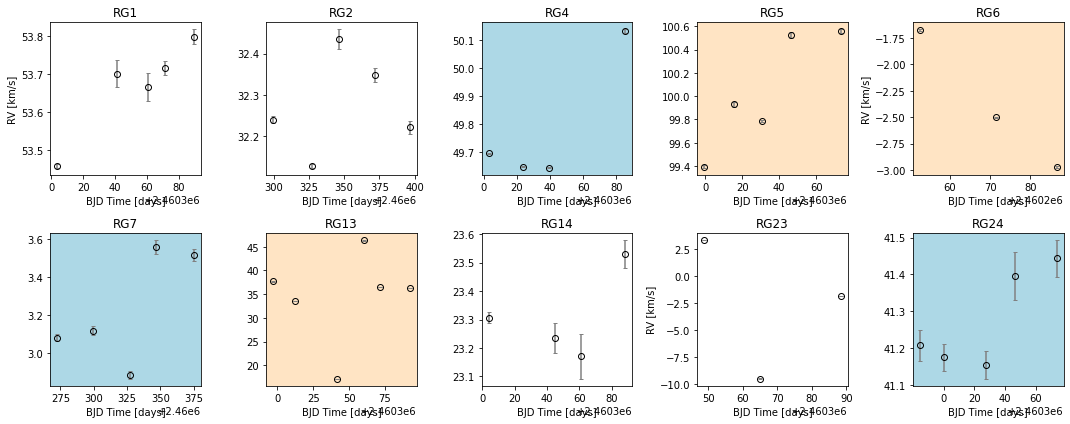

In [38]:
#PLOT_PARAMS(LS=12)
plt.figure(figsize=(15,6))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(2,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        yerr = obj_dir[obj]['err']
        print(obj, K0)
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')
        title = 'RG%s'%obj
        plt.title(title)
        if title in ['RG13','RG5','RG6']:
            ax.set_facecolor('bisque')
        elif title in ['RG4','RG24','RG13','RG7']:
            ax.set_facecolor('lightblue')
    plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')

plt.tight_layout()
# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

In [ ]:
ss

In [ ]:
import thejoker as tj


In [ ]:
def test_tj(obj):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    data['rv_err'] = obj_dir[obj]['err']
    t = Time(sub_tbl["bjd"], format="jd", scale="tcb")
    data = tj.RVData(t=t, rv=sub_tbl["rv"], rv_err=sub_tbl["rv_err"])

    #t = Time(data["bjd"], format="jd", scale="tcb")
#     data = tj.RVData(t=t, rv=sub_tbl["rv"], rv_err=sub_tbl["rv_err"])
test_tj('RG4')

In [ ]:
rnd = np.random.default_rng(seed=42)